In [1]:
##################################
#                                #
# regression_TOH.ipynb           #
# Created 2023-05-20             #
# Akhil Garg, akhil@akhilgarg.ca #
#                                #
##################################

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
import pickle
import os
import itertools

from sklearn import preprocessing
from sklearn import pipeline
from sklearn import linear_model
from sklearn import metrics
from datetime import datetime

import matplotlib.pyplot as plt

#pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
imputation_file = '2024-09-19 AMR_imputation_TOH.xlsx'

data = pd.read_excel(imputation_file)

# From data point 5172 onwards
#data = data[5172:]

# Only use data from 2022 onwards
data = data[data['Year (based on culture)']>=2022]

data

,AgeCat,Sex,Year (based on culture),CULTURE_DESCRIPTION,FINAL,PriorGNOrg,ADMIT_SVC,Acquisition,RecentHospitalization,ClinicalESBL,...,Daptomycin_PGNO_imp,Vancomycin_PGNO_imp,Linezolid_PGNO_imp,Amikacin_PGNO_imp,Tobramycin_PGNO_imp,Gentamicin_PGNO_imp,Clindamycin_PGNO_imp,Doxycycline_PGNO_imp,Erythromycin_PGNO_imp,TMPSMX_PGNO_imp
3625,70-75,M,2022,BLOOD CULTURE,Klebsiella pneumoniae,not_applicable,Medical,Community,0,0,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
3626,80-85,M,2022,URINE QUANTITATIVE CULTURE,Klebsiella variicola,not_applicable,Medical,Community,0,0,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
3627,75-80,M,2022,URINE QUANTITATIVE CULTURE,Enterobacter species,not_applicable,Medical,ICU,0,0,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
3628,70-75,F,2022,URINE QUANTITATIVE CULTURE,Escherichia coli,not_applicable,Medical,Community,1,0,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
3629,65-70,F,2022,URINE QUANTITATIVE CULTURE,Pseudomonas aeruginosa,not_applicable,Surgical,Community,0,0,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6605,65-70,M,2023,URINE CULTURE (ADULT),Pseudomonas aeruginosa,not_applicable,Surgical,Hospital,1,0,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
6606,45-50,M,2023,URINE CULTURE (ADULT),Escherichia coli,not_applicable,Medical,Community,0,0,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
6607,80-85,F,2023,URINE CULTURE (ADULT),Escherichia coli,not_applicable,Surgical,ICU,0,0,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable
6608,85-90,F,2023,BLOOD CULTURE,Escherichia coli,not_applicable,Medical,Community,0,0,...,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable,not_applicable


In [3]:
# List of output antibiotics
output_antibiotics = ['Penicillin_FINAL_imp','Amoxiclav_FINAL_imp','Ampicillin_FINAL_imp','Cloxacillin_FINAL_imp','Piptaz_FINAL_imp','Cefazolin_FINAL_imp','Ceftriaxone_FINAL_imp','Ceftazidime_FINAL_imp','Ertapenem_FINAL_imp','Meropenem_FINAL_imp','Ciprofloxacin_FINAL_imp','Levofloxacin_FINAL_imp','Moxifloxacin_FINAL_imp','Daptomycin_FINAL_imp','Vancomycin_FINAL_imp','Linezolid_FINAL_imp','Amikacin_FINAL_imp','Tobramycin_FINAL_imp','Gentamicin_FINAL_imp','Clindamycin_FINAL_imp','Doxycycline_FINAL_imp','Erythromycin_FINAL_imp','TMPSMX_FINAL_imp']
output_antibiotics = ['Meropenem_FINAL_imp','Piptaz_FINAL_imp','Ceftazidime_FINAL_imp','Ceftriaxone_FINAL_imp','Ciprofloxacin_FINAL_imp','Tobramycin_FINAL_imp']

# Missingness susceptibilities for each antibiotic
print('Missingness')
for abx in output_antibiotics:
    missingness = data[data[abx]=='no_data'].shape[0] / data.shape[0]
    print('{:<15} {:>6.2f}%'.format(abx.split('_')[0],missingness*100))
    
# Piperacillin-tazobactam or tobramycin missingness
print('{:<15} {:>6.2f}%'.format('Piptaz or tobra',
      data[(data['Piptaz_FINAL_imp']=='no_data')|(data['Tobramycin_FINAL_imp']=='no_data')].shape[0]/data.shape[0]*100))

Missingness
Meropenem         0.00%
Piptaz            1.21%
Ceftazidime       0.44%
Ceftriaxone       1.31%
Ciprofloxacin     0.67%
Tobramycin        7.10%
Piptaz or tobra   7.60%


## Preprocessing

In [4]:
# Add a column for hospital site 
data['hosp_Sunnybrook'] = 0
data['hosp_TOH'] = 1
data['hosp_Trillium'] = 0

In [5]:
# Change missing data in the final output imputation to be resistant
data[output_antibiotics] = data[output_antibiotics].replace('no_data','RESISTANT')

# Convert susceptible/intermediate/resistant to numerical categorical values
data = data.replace({'SUSCEPTIBLE':0,'INTERMEDIATE':1,'RESISTANT':1})

# Convert age to a continuous variable
age_categories = {'<40'  :30, 
                  '40-45':42.5,
                  '45-50':47.5,
                  '50-55':52.5,
                  '55-60':57.5,
                  '60-65':62.5,
                  '65-70':67.5,
                  '70-75':72.5,
                  '75-80':77.5,
                  '80-85':82.5,
                  '85-90':87.5,
                  '>90'  :95
                 }
data['Age'] = data['AgeCat'].replace(age_categories).infer_objects()

# Rename acquisition locations to match future code
data['Acquisition'] = data['Acquisition'].replace({'Community':'community','Hospital':'ward'})

# Rename admitting service to match future code
data['ADMIT_SVC'] = data['ADMIT_SVC'].replace({'Medical':'medical','Surgical':'surgical'})

# One hot encode categories
one_hot_data = pd.get_dummies(data, columns=['Sex','Acquisition','ADMIT_SVC'],
                                        prefix= ['sex','acquisition','adm_service'])

### Encode prior antibiotic exposure

In [6]:
# Create a column of prior exposure to either penicillins or aminoglycosides
conditions = [((one_hot_data['PriorPenicillin']==0) & (one_hot_data['PriorAMG']==0)),
              ((one_hot_data['PriorPenicillin']==1) | (one_hot_data['PriorAMG']==1))]
# default -1 value should not occur, and is an error-checking mechanism
one_hot_data['PriorPenicillin_or_AMG'] = np.select(conditions, [0,1], default=-1)

# Create new categories of "prior non-[antibiotic class]"
one_hot_data['PriorNonCephalosporin'] = one_hot_data[['PriorAMG','PriorCarbapenem','PriorFQ','PriorOtherAbx','PriorPenicillin']].any(axis='columns')
one_hot_data['PriorNonCarbapenem'] = one_hot_data[['PriorAMG','PriorCephalosporin','PriorFQ','PriorOtherAbx','PriorPenicillin']].any(axis='columns')
one_hot_data['PriorNonPenicillin'] = one_hot_data[['PriorAMG','PriorCephalosporin','PriorFQ','PriorOtherAbx','PriorCarbapenem']].any(axis='columns')
one_hot_data['PriorNonFQ'] = one_hot_data[['PriorAMG','PriorCephalosporin','PriorPenicillin','PriorOtherAbx','PriorCarbapenem']].any(axis='columns')
one_hot_data['PriorNonAMG'] = one_hot_data[['PriorFQ','PriorCephalosporin','PriorPenicillin','PriorOtherAbx','PriorCarbapenem']].any(axis='columns')
one_hot_data['PriorNonOtherAbx'] = one_hot_data[['PriorFQ','PriorAMG','PriorCephalosporin','PriorPenicillin','PriorCarbapenem']].any(axis='columns')

one_hot_data['PriorNonPenicillin_or_AMG'] = one_hot_data[['PriorFQ','PriorCephalosporin','PriorCarbapenem']].any(axis='columns')

### List of antibiotics and classes to run regression on


In [7]:
antibiotic_list = ['Cefazolin','Ceftriaxone','Ceftazidime','Piptaz','Meropenem','Ciprofloxacin','Tobramycin','TMPSMX']

# New antibiotic list as of 2024-03-26:
antibiotic_list = ['Meropenem','Piptaz','Ceftazidime','Ceftriaxone','Ciprofloxacin']

antibiotic_classes = {'Cefazolin':'Cephalosporin','Ceftriaxone':'Cephalosporin','Ceftazidime':'Cephalosporin',
                      'Piptaz':'Penicillin','Meropenem':'Carbapenem','Ciprofloxacin':'FQ','Tobramycin':'AMG',
                      'TMPSMX':'OtherAbx','Piptaz_or_Tobramycin':'Penicillin_or_AMG'}

In [8]:
# Add a column for combined pip-taz and tobramycin via multiplication    
# (would only be 1 (resistant) if both are 1 (resistant), otherwise 0 (susceptible))
one_hot_data['Piptaz_or_Tobramycin_FINAL_imp'] = (one_hot_data['Piptaz_FINAL_imp'])*(one_hot_data['Tobramycin_FINAL_imp'])

### Handling previous antibiotic exposure and resistance

In [9]:
# Look for antibiotic resistance during previous gram negative infection
def previous_infection(priorGNOrg,prior_susceptibility):
    '''
    For a given antibiotic, takes a previous gram negative organism and its susceptibility as input
    Outputs:
        0 if no previous gram negative organism
        0 if previous gram negative organism without susceptibility data
        1 if previous susceptible gram negative organism
        2 if previous resistant gram negative organism 
    '''
    
    if priorGNOrg=='not_applicable': return 0
    elif prior_susceptibility=='no_data': return 0

    # 0 = prior susceptible, 1 = prior resistant
    elif (priorGNOrg!='not_applicable') and (prior_susceptibility==0): return 1
    elif (priorGNOrg!='not_applicable') and (prior_susceptibility==1): return 2
        
    else: raise ValueError('Inputs passed to the previous_infection function are invalid.')

# Add a column for previous susceptibility to the particular antibiotic
for antibiotic in antibiotic_list:
    one_hot_data[antibiotic+'Resistance'] = one_hot_data.apply(lambda x: previous_infection(x['PriorGNOrg'],x[antibiotic+'_PGNO_imp']), axis=1)

In [10]:
# Special case of piperacillin-tazobactam plus tobramycin

    # 0 if no previous gram negative organism
    # 0 if previous gram negative organism without susceptibility data for either antibiotic
    # 1 if previous resistance to only one of the two antibiotics (the other may be susceptible or have no data)
    # 2 if previous resistance to both antibiotics

# Note that this behaviour is slightly different from the function for single antibiotic susceptibility histories,
    # which would assign a 1 if the previous antibiotic was susceptible

# 0 = prior susceptible, 1 = prior resistant
conditions = [(one_hot_data['PriorGNOrg']=='not_applicable'),              
              ((one_hot_data['Piptaz_PGNO_imp']=='no_data') & (one_hot_data['Tobramycin_PGNO_imp']=='no_data')),
              ((one_hot_data['Piptaz_PGNO_imp']==0) & (one_hot_data['Tobramycin_PGNO_imp']==0)),
              
              ((one_hot_data['Piptaz_PGNO_imp']==0) & (one_hot_data['Tobramycin_PGNO_imp']=='no_data')),
              ((one_hot_data['Piptaz_PGNO_imp']=='no_data') & (one_hot_data['Tobramycin_PGNO_imp']==0)),  
              
              ((one_hot_data['Piptaz_PGNO_imp']==1) & (one_hot_data['Tobramycin_PGNO_imp']=='no_data')),
              ((one_hot_data['Piptaz_PGNO_imp']=='no_data') & (one_hot_data['Tobramycin_PGNO_imp']==1)),
              
              ((one_hot_data['Piptaz_PGNO_imp']==1) & (one_hot_data['Tobramycin_PGNO_imp']==0)),
              ((one_hot_data['Piptaz_PGNO_imp']==0) & (one_hot_data['Tobramycin_PGNO_imp']==1)),
              
              ((one_hot_data['Piptaz_PGNO_imp']==1) & (one_hot_data['Tobramycin_PGNO_imp']==1))]
values = [0,0,0,0,0,1,1,1,1,2]
# default -1 value should not occur, and is an error-checking mechanism
one_hot_data['Piptaz_or_TobramycinResistance'] = np.select(conditions, values, default=-1)

# if 'Piptaz_or_Tobramycin' not in antibiotic_list:
#     antibiotic_list.append('Piptaz_or_Tobramycin')

In [11]:
# Convert prior resistance history into one-hot encoding

for antibiotic in antibiotic_list:
    one_hot_data[antibiotic+'Resistance'] = one_hot_data[antibiotic+'Resistance'].replace({0:'no_prior',
                                                                                           1:'susceptible',
                                                                                           2:'nonsusceptible'
                                                                                          })
    one_hot_data = pd.get_dummies(one_hot_data,columns=[antibiotic+'Resistance'])

### Organisms isolated

In [12]:
one_hot_data['FINAL'].value_counts()

FINAL
Escherichia coli                                   1480
Klebsiella pneumoniae                               419
Pseudomonas aeruginosa                              331
Proteus mirabilis                                   153
Enterobacter cloacae                                122
Serratia marcescens                                  85
Klebsiella oxytoca                                   83
Klebsiella variicola                                 73
Klebsiella (Enterobacter) aerogenes                  39
Citrobacter freundii                                 32
Enterobacter species                                 25
Citrobacter koseri                                   24
Morganella morganii                                  22
Salmonella species                                   10
Acinetobacter species                                 7
Raoultella (Klebsiella) ornithinolytica               7
Proteus vulgaris                                      6
Haemophilus influenzae, beta-lactamase POS

# Regression Function

In [13]:
regression_inputs = ['Age','sex_M',
                     'acquisition_ICU','acquisition_ward',
                     'adm_service_surgical',
                     'RecentHospitalization',
                     
                     'Prior[Class]Exposure','Prior[NonClass]Exposure',
                     '[Antibiotic]_susceptible','[Antibiotic]_nonsusceptible',
                     
                     'ClinicalESBL']

print('Number of regression inputs: {}'.format(len(regression_inputs)))

Number of regression inputs: 11



Logistic regression model for Meropenem:

Logistic Regression Coefficients
MeropenemResistance_nonsusceptible          3.6396
PriorCarbapenem                             1.9017
acquisition_ICU                             0.8858
acquisition_ward                            0.8618
adm_service_surgical                        0.5613
sex_M                                       0.5483
PriorNonCarbapenem                          0.3697
MeropenemResistance_susceptible             0.2853
RecentHospitalization                       0.1842
Age                                        -0.0134
ClinicalESBL                               -0.1214

Probability of susceptibility: prediction outputs
Susceptible isolates min:     0.13
                     median:  0.99
                     mean:    0.98
                     max:     1.00
                     
Resistant isolates   min:     0.28
                     median:  0.97
                     mean:    0.89
                     max:     1.00
          

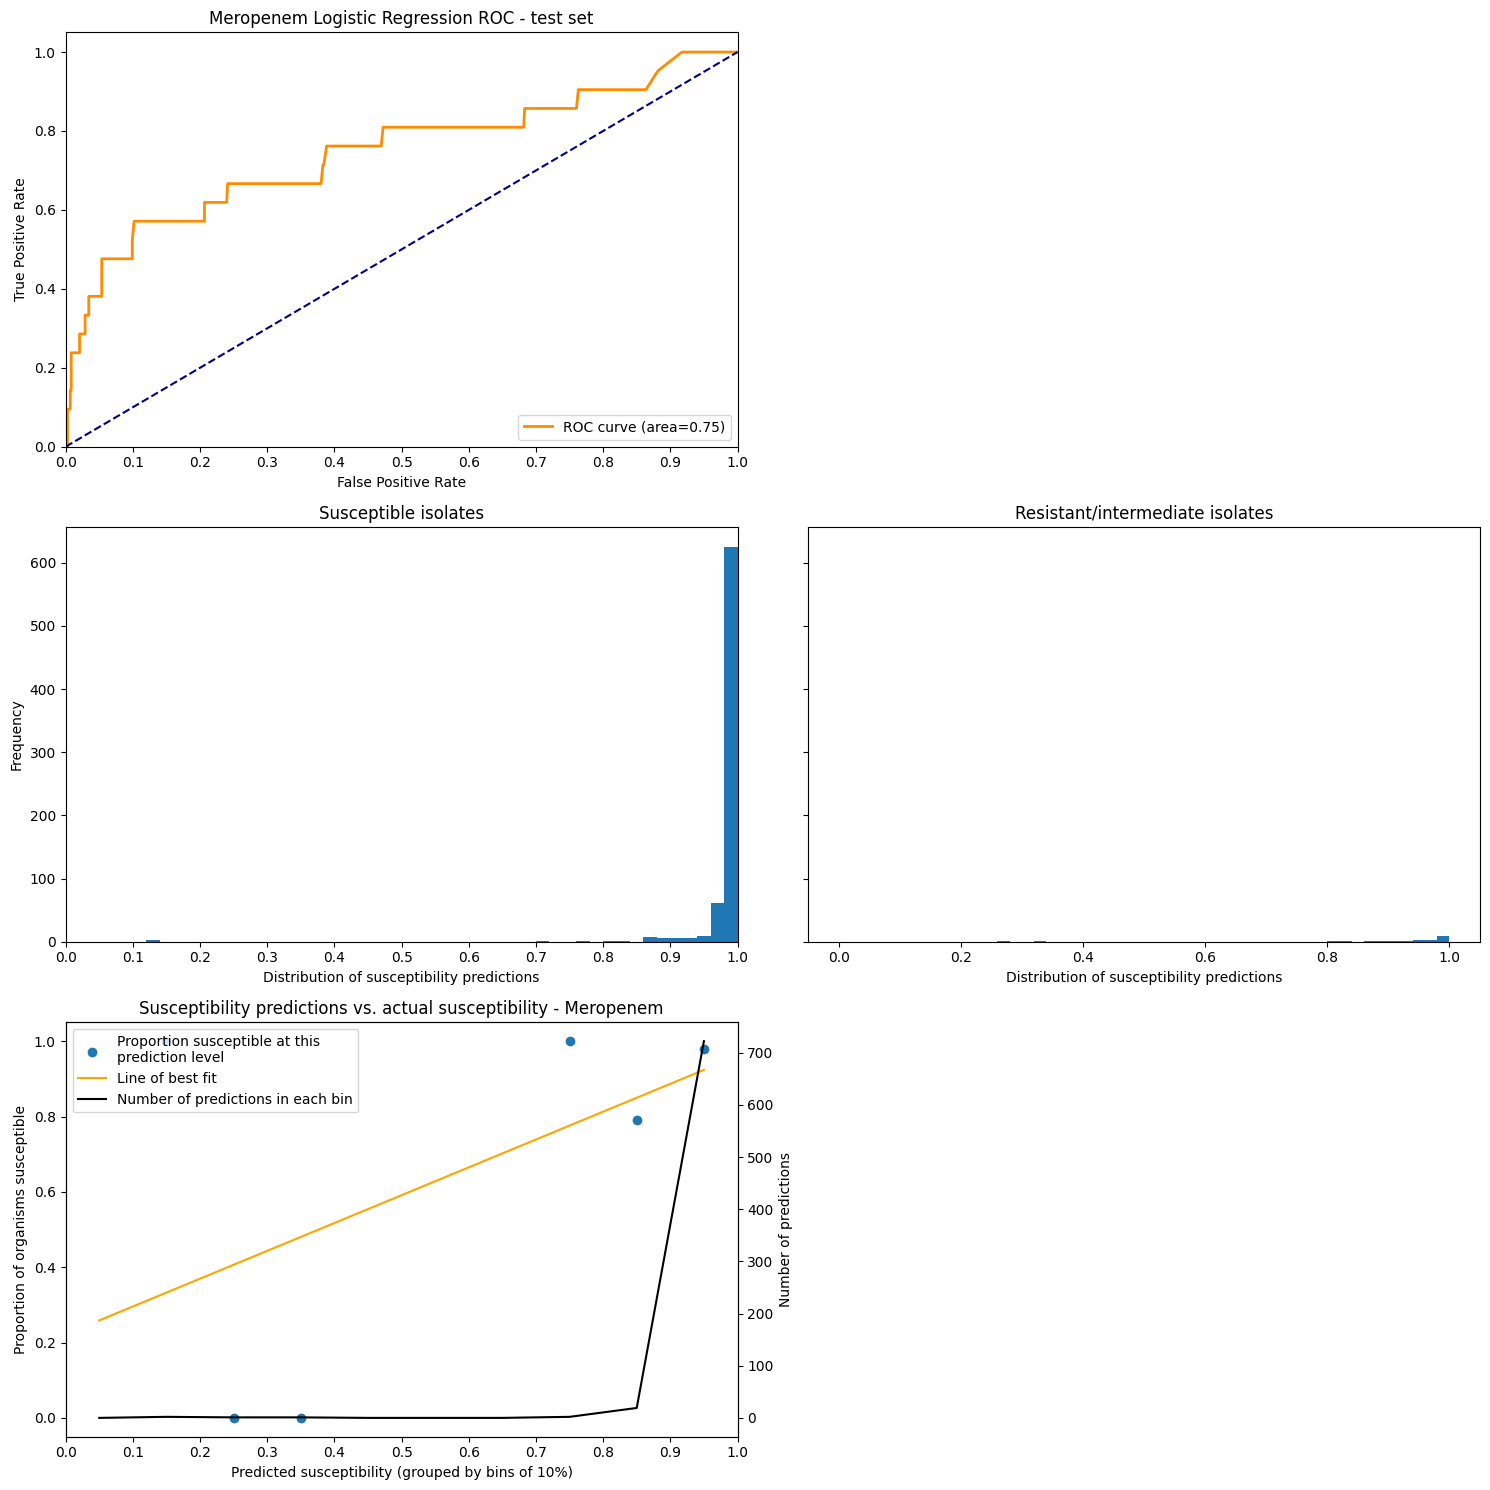


Logistic regression model for Piptaz:

Logistic Regression Coefficients
PiptazResistance_nonsusceptible             1.5124
ClinicalESBL                                1.0587
PriorNonPenicillin                          0.6510
acquisition_ICU                             0.4347
acquisition_ward                            0.3441
sex_M                                       0.1773
PriorPenicillin                             0.0750
Age                                        -0.0115
RecentHospitalization                      -0.1505
adm_service_surgical                       -0.2920
PiptazResistance_susceptible               -1.2487

Probability of susceptibility: prediction outputs
Susceptible isolates min:     0.21
                     median:  0.90
                     mean:    0.87
                     max:     0.97
                     
Resistant isolates   min:     0.32
                     median:  0.87
                     mean:    0.82
                     max:     0.92
             

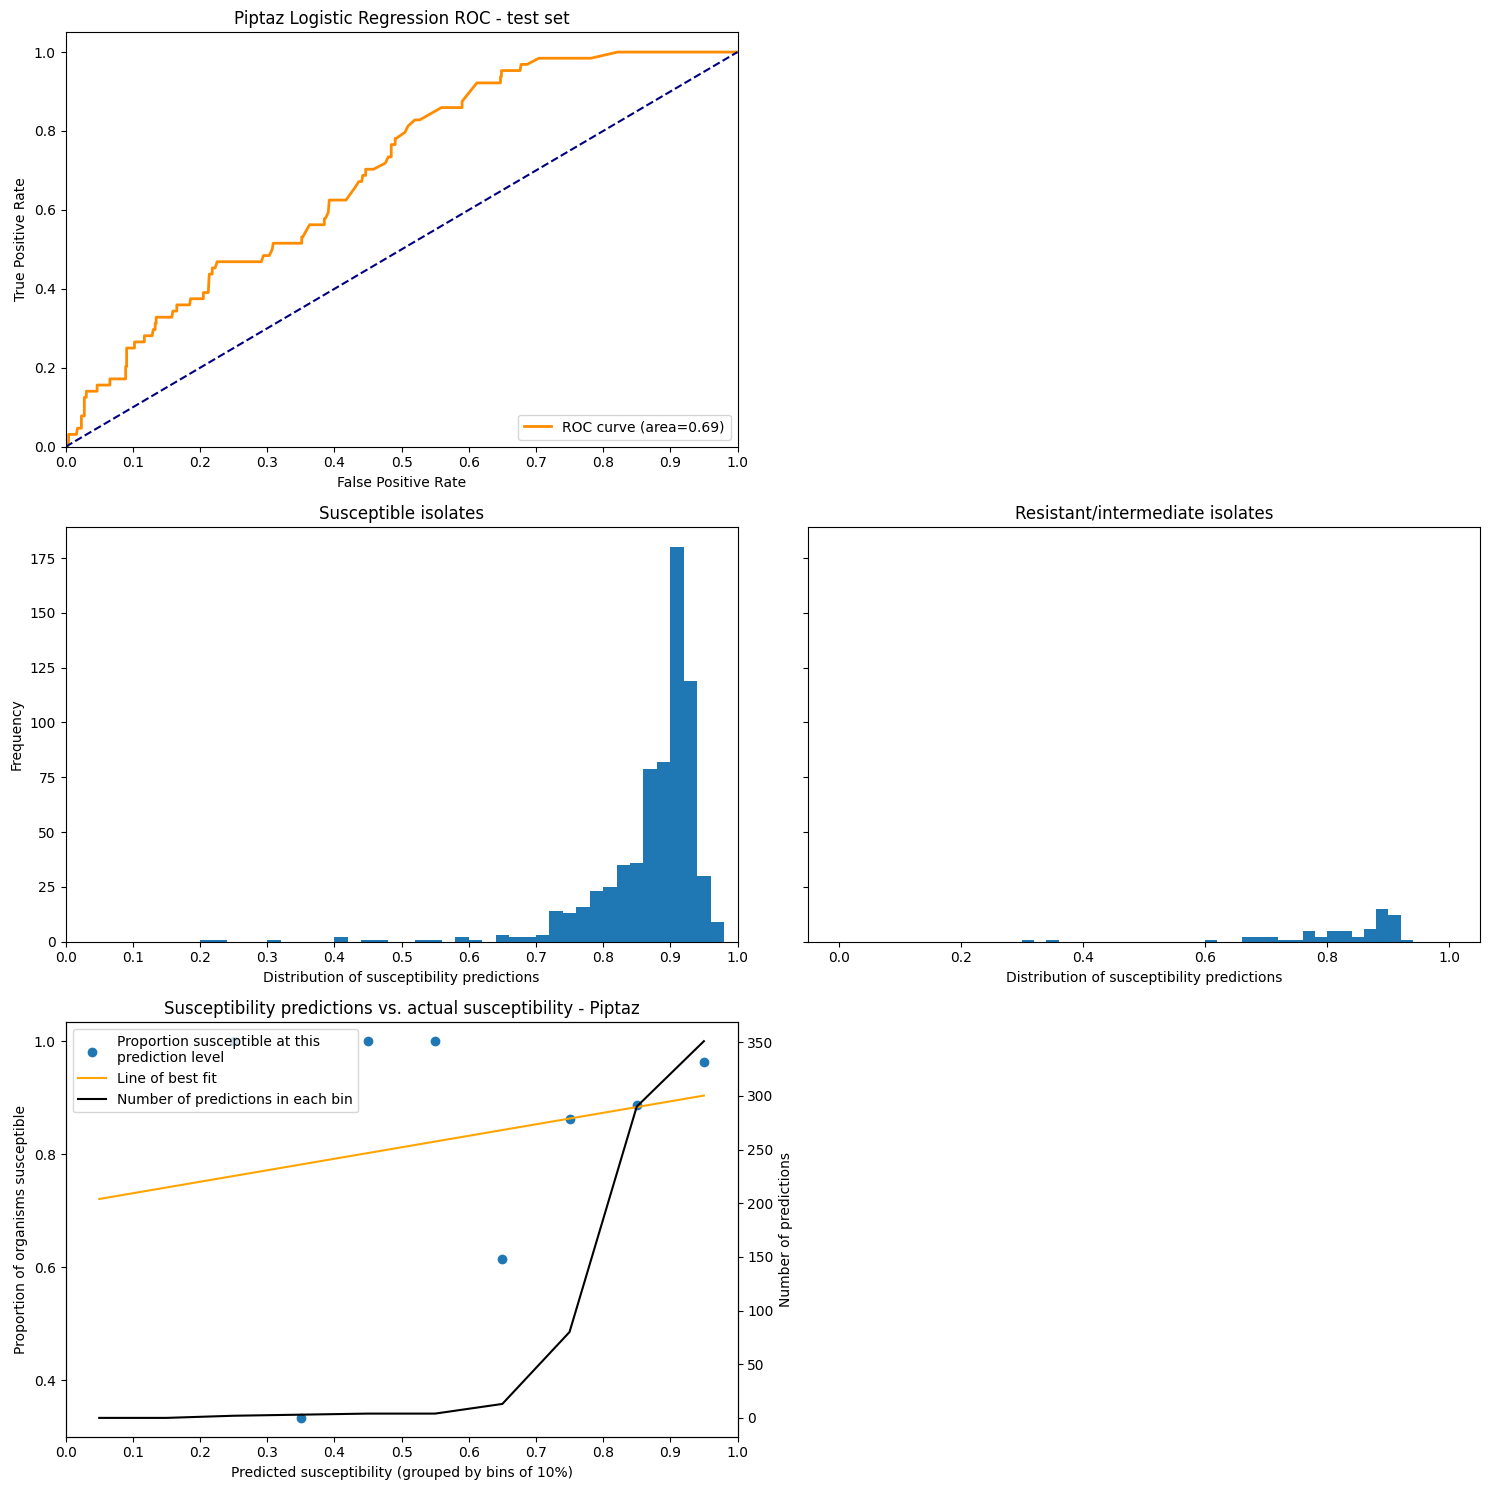


Logistic regression model for Ceftazidime:

Logistic Regression Coefficients
CeftazidimeResistance_nonsusceptible        1.5839
ClinicalESBL                                1.5380
PriorCephalosporin                          0.7302
acquisition_ICU                             0.5194
sex_M                                       0.3833
PriorNonCephalosporin                       0.3652
acquisition_ward                            0.1308
Age                                        -0.0046
RecentHospitalization                      -0.1159
adm_service_surgical                       -0.1429
CeftazidimeResistance_susceptible          -1.6136

Probability of susceptibility: prediction outputs
Susceptible isolates min:     0.07
                     median:  0.83
                     mean:    0.81
                     max:     0.97
                     
Resistant isolates   min:     0.06
                     median:  0.77
                     mean:    0.68
                     max:     0.93
        

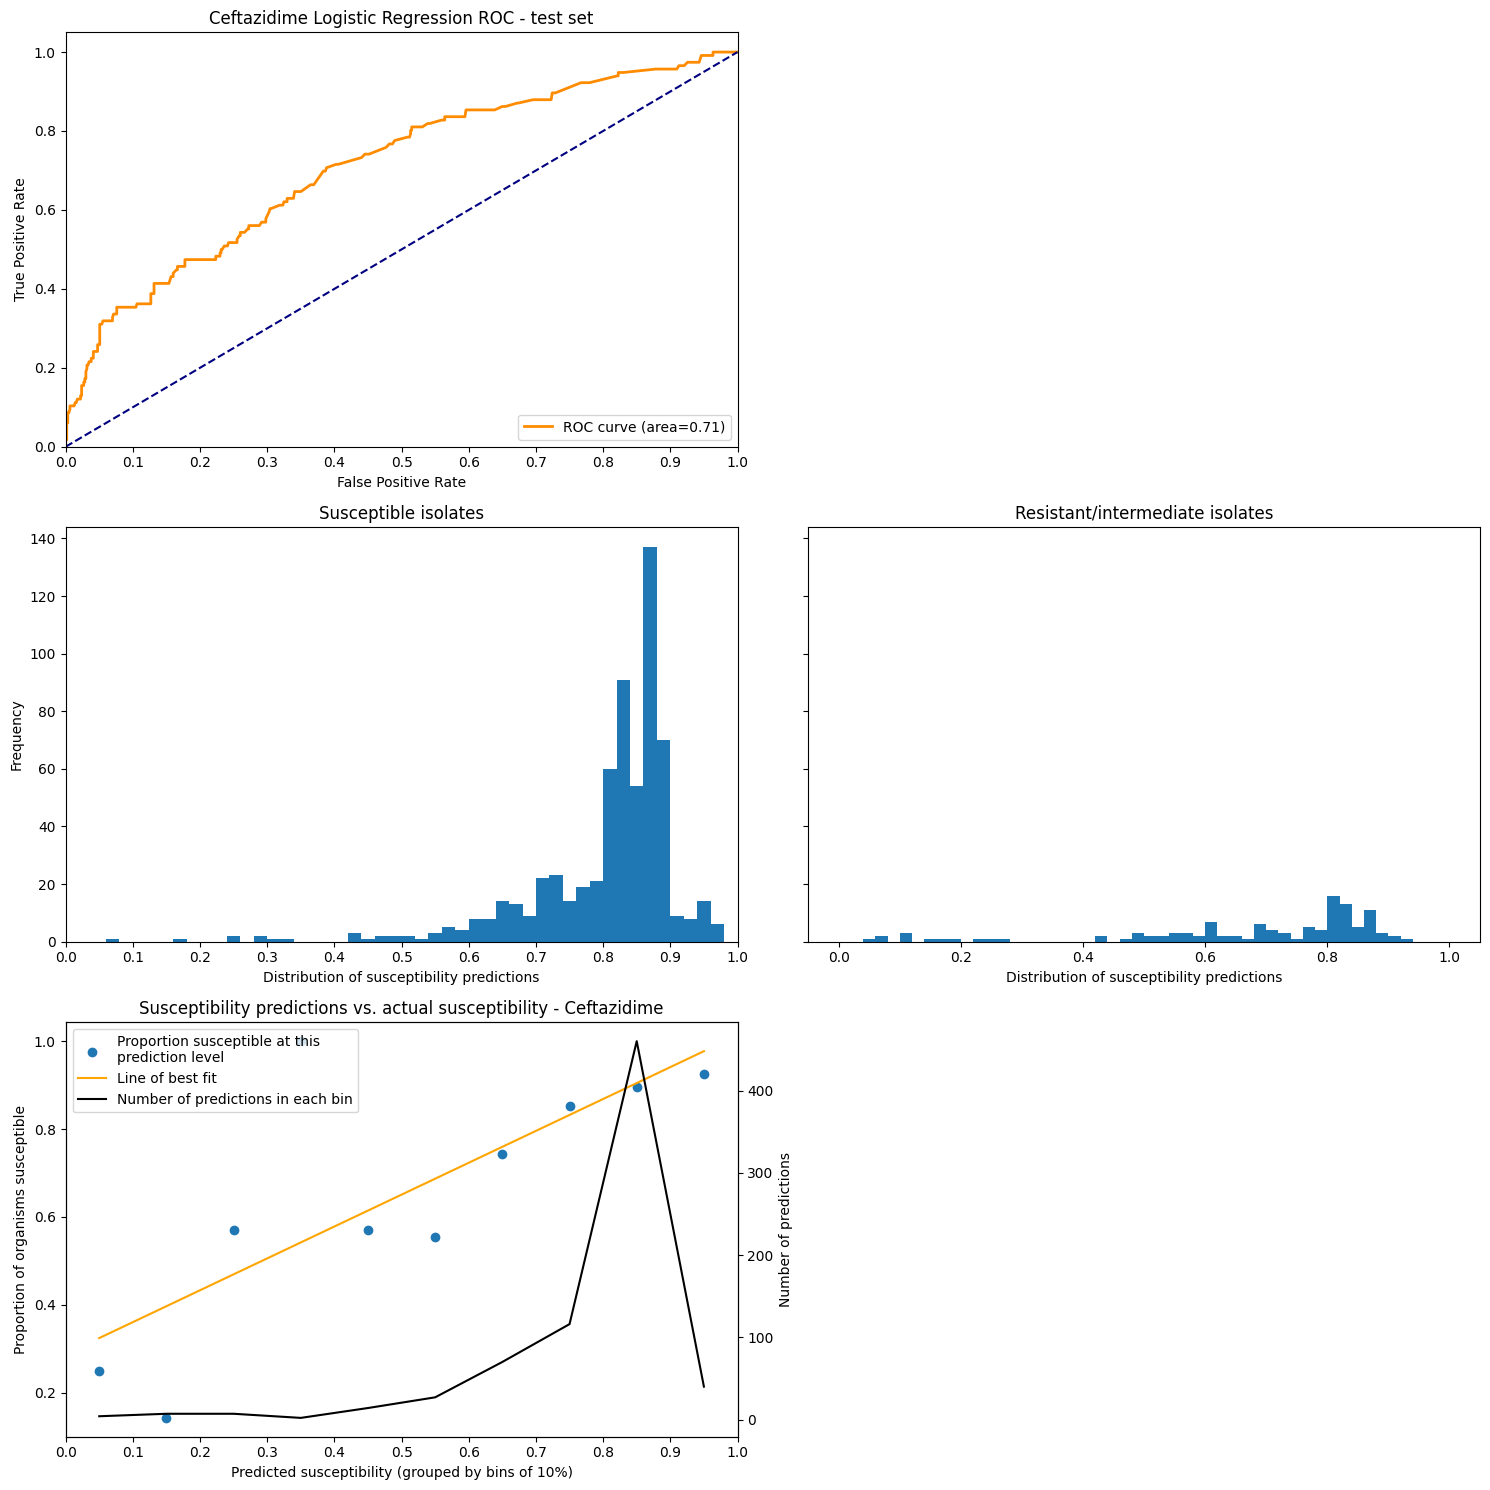


Logistic regression model for Ceftriaxone:

Logistic Regression Coefficients
CeftriaxoneResistance_nonsusceptible        1.3285
ClinicalESBL                                1.2112
PriorCephalosporin                          1.0226
PriorNonCephalosporin                       0.6774
acquisition_ICU                             0.6767
sex_M                                       0.5977
acquisition_ward                            0.0889
Age                                        -0.0032
adm_service_surgical                       -0.0173
RecentHospitalization                      -0.2580
CeftriaxoneResistance_susceptible          -1.4968

Probability of susceptibility: prediction outputs
Susceptible isolates min:     0.09
                     median:  0.73
                     mean:    0.71
                     max:     0.95
                     
Resistant isolates   min:     0.03
                     median:  0.59
                     mean:    0.53
                     max:     0.88
        

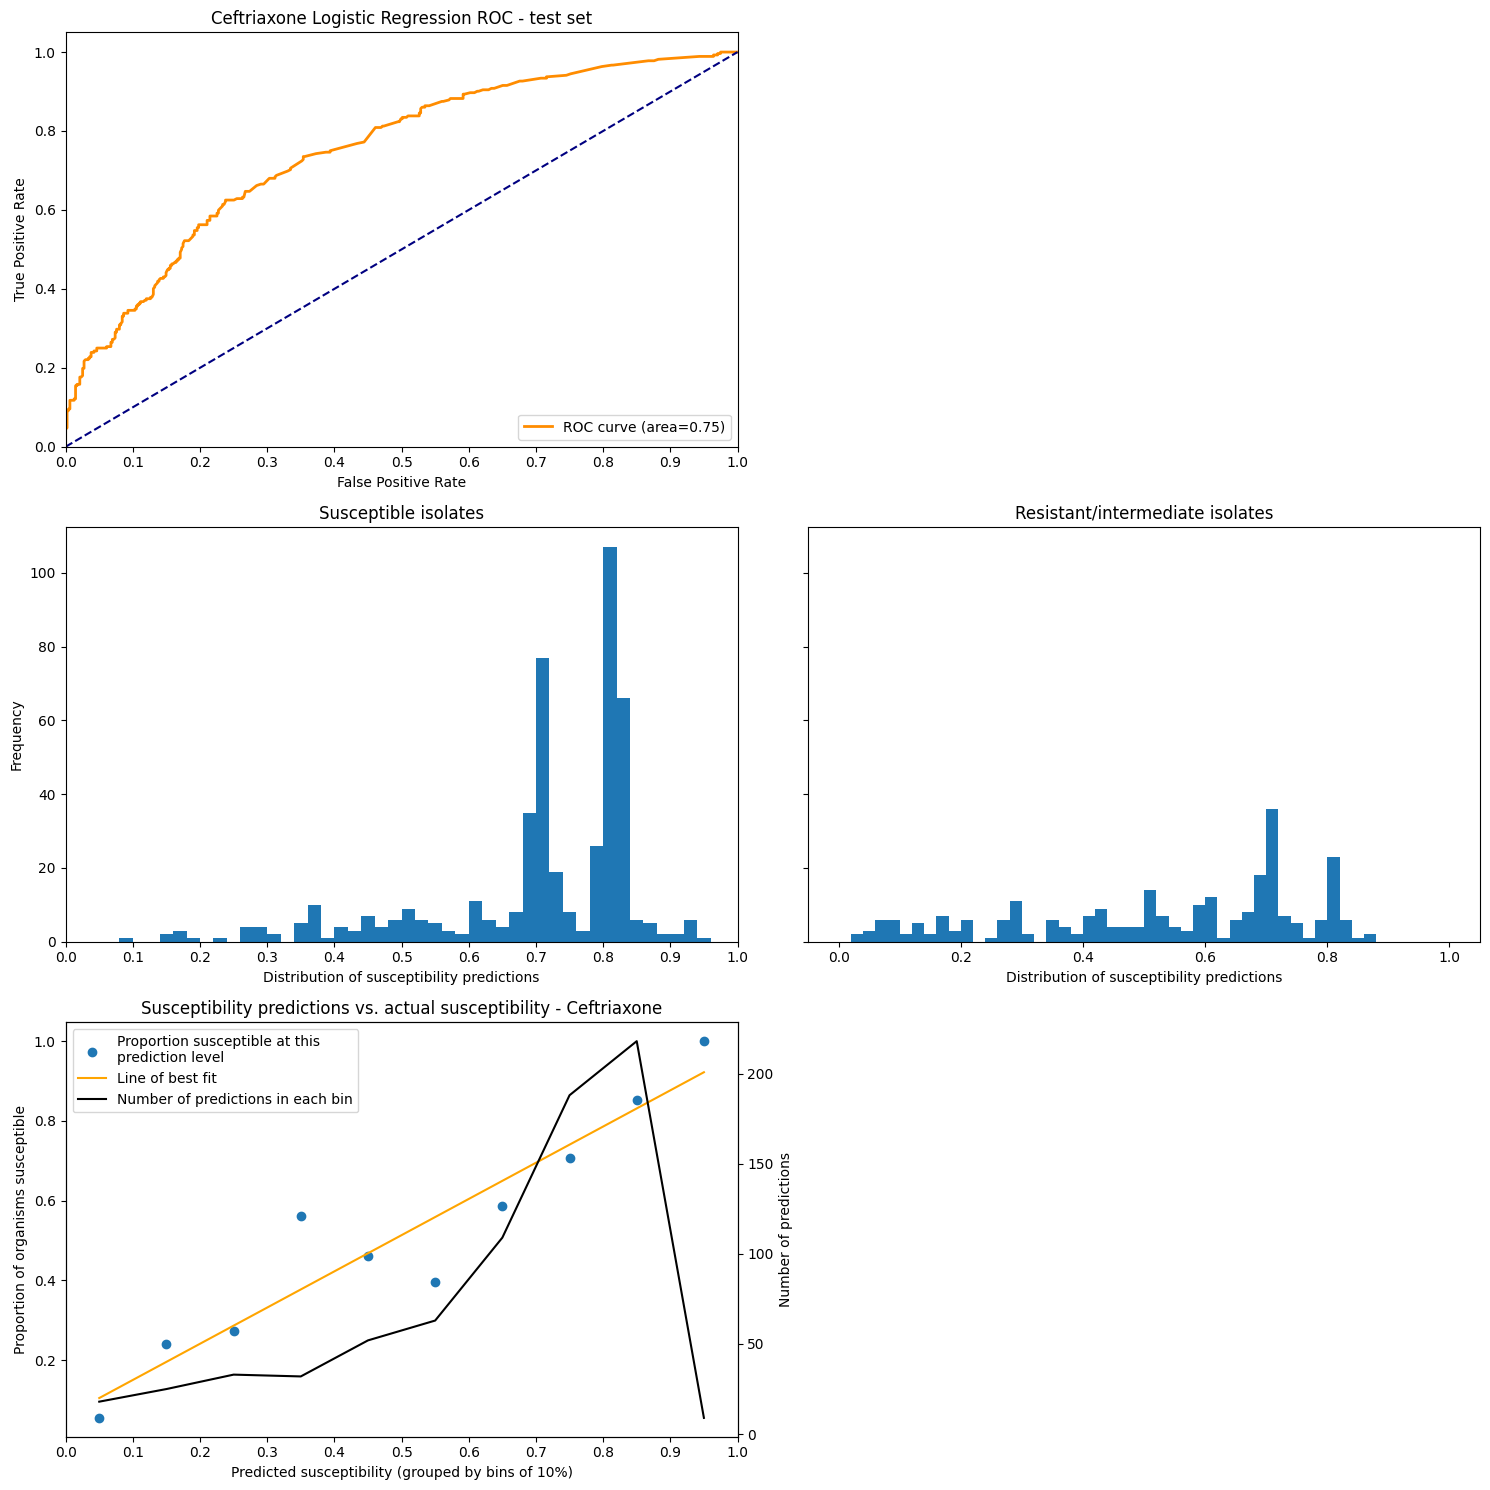


Logistic regression model for Ciprofloxacin:

Logistic Regression Coefficients
CiprofloxacinResistance_nonsusceptible      1.7464
ClinicalESBL                                1.4217
PriorFQ                                     0.9091
PriorNonFQ                                  0.2690
sex_M                                       0.0923
Age                                        -0.0014
RecentHospitalization                      -0.1043
adm_service_surgical                       -0.3194
acquisition_ICU                            -0.4556
acquisition_ward                           -0.4999
CiprofloxacinResistance_susceptible        -0.6015

Probability of susceptibility: prediction outputs
Susceptible isolates min:     0.12
                     median:  0.79
                     mean:    0.79
                     max:     0.92
                     
Resistant isolates   min:     0.05
                     median:  0.78
                     mean:    0.69
                     max:     0.88
      

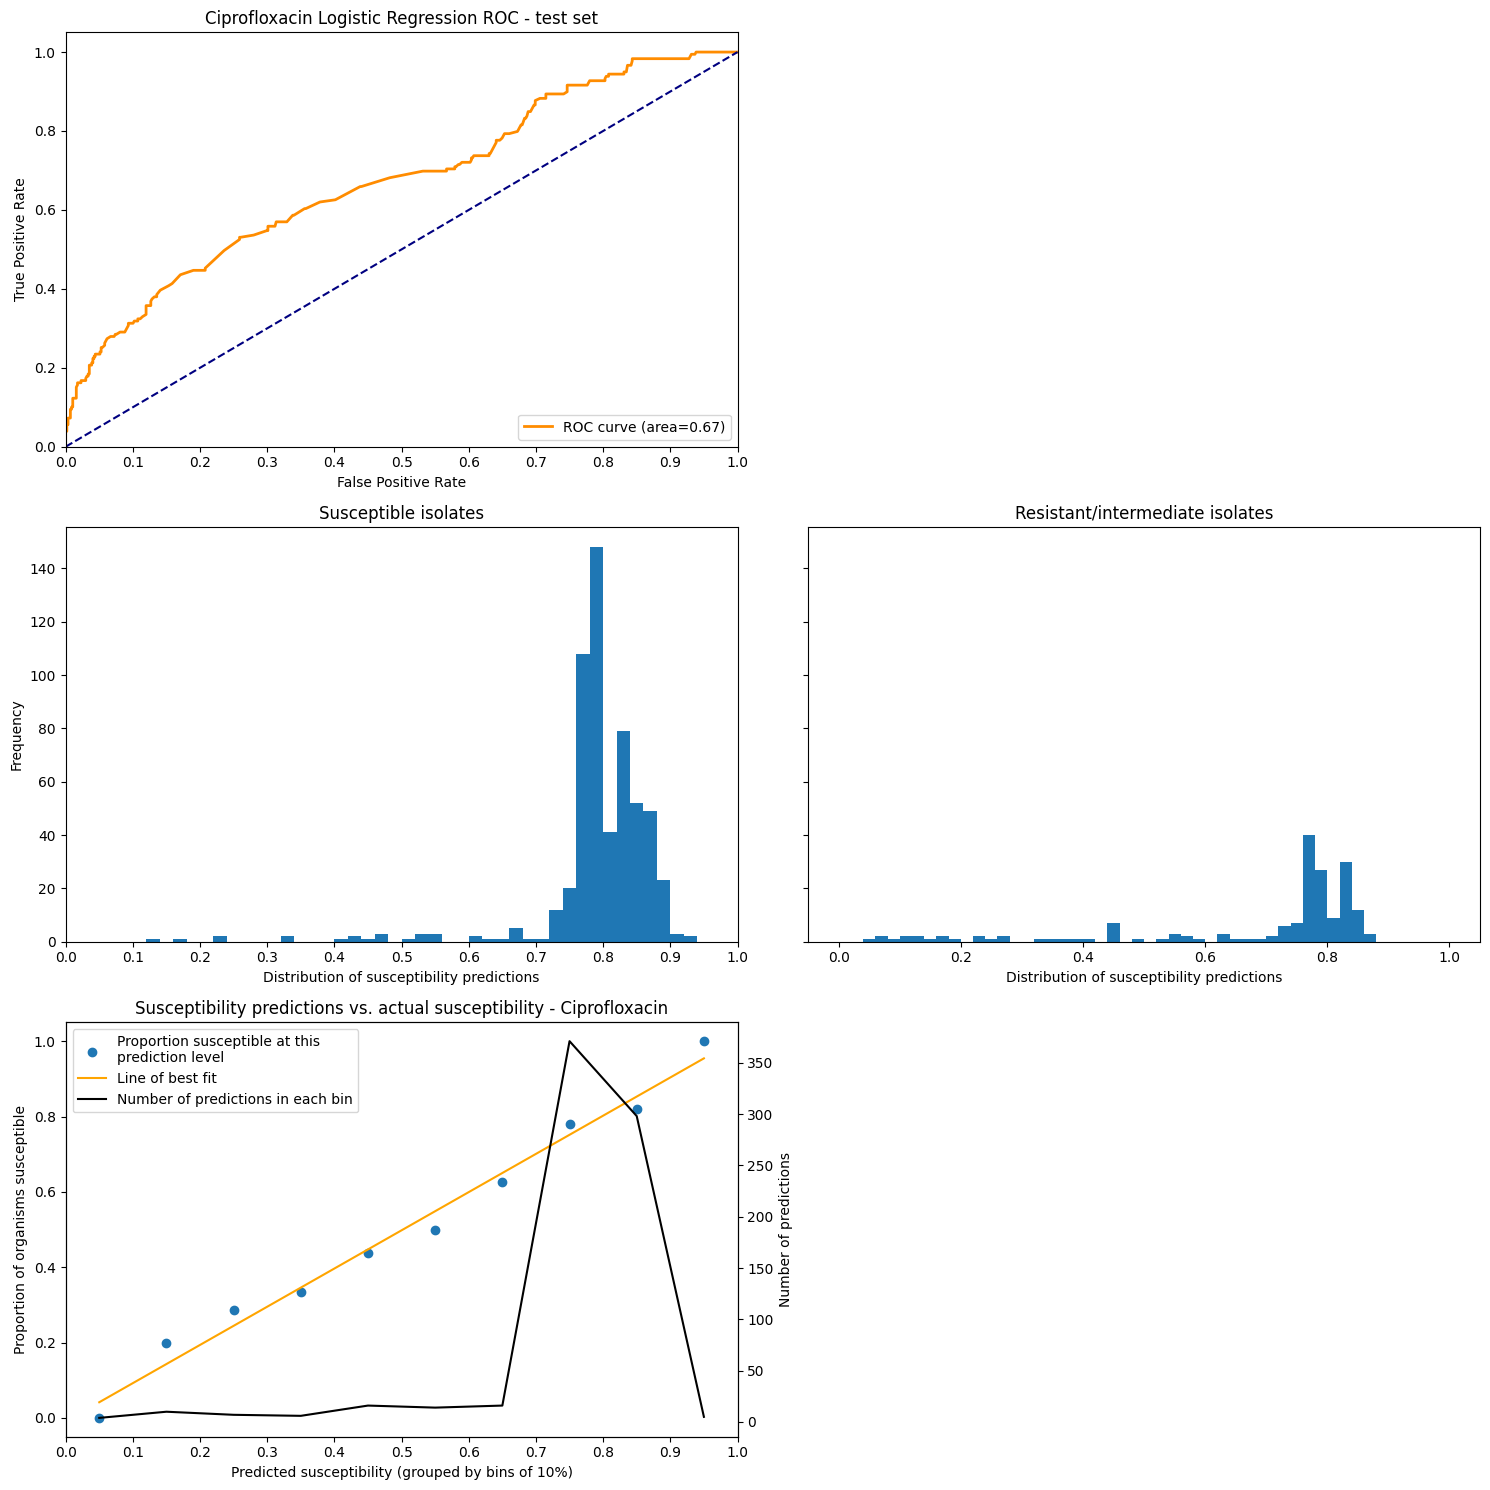

In [14]:
# Divide data into temporal 80-20 train-test sets
# Update 2024-05-23: instead of 80-20 will do 50-50
# Update 2024-06-11: 75-25 split
train_set, test_set= np.split(one_hot_data, [int(.75 *len(one_hot_data))])

# Collect a list of AUCs of the receiver operating characteristic
AUCROCs = []

for antibiotic in antibiotic_list:
    
    print('\nLogistic regression model for {}:\n'.format(antibiotic))
    
    regression_inputs = ['Age','sex_M',                         
                         'acquisition_ICU','acquisition_ward',
                         'adm_service_surgical','RecentHospitalization',
                         
                         'Prior'+antibiotic_classes[antibiotic],
                         'PriorNon'+antibiotic_classes[antibiotic],
                          antibiotic+'Resistance_susceptible',antibiotic+'Resistance_nonsusceptible',
                         
                         'ClinicalESBL'
                        ]
    
    # 0 = susceptible, 1 = resistant
    X_train = train_set[regression_inputs]
    X_test  = test_set [regression_inputs]
    Y_train = train_set[antibiotic+'_FINAL_imp']
    Y_test  = test_set [antibiotic+'_FINAL_imp']
    
    reg = linear_model.LogisticRegression(max_iter=500,penalty=None)
    reg.fit(X_train,Y_train)
    
    # Coefficients sorted by size
    print('Logistic Regression Coefficients')
    for i in sorted(zip(reg.coef_[0], reg.feature_names_in_),reverse=True):
        print('{:<42} {: .4f}'.format(i[1],i[0]))

    # Zip together prediction values and actual test values
    # Then sort by susceptible strains first, followed by prediction values
    predict_results = sorted((zip(reg.predict_proba(X_test)[:,0],Y_test)),key=lambda x:(x[1],x[0]))

    # Separate out predictions on susceptible and resistant isolates
    susceptible_isolates = []
    resistant_isolates   = []
    for i in predict_results:
        if i[1]==1:
            resistant_isolates.append(i[0])
        else: susceptible_isolates.append(i[0])

    # Print descriptive statistics
    print('\nProbability of susceptibility: prediction outputs')

    print('''Susceptible isolates min: {:> 8.2f}
                     median: {: .2f}
                     mean:   {: .2f}
                     max:    {: .2f}
                     '''.format(min(susceptible_isolates),
                                np.median(susceptible_isolates),
                                np.mean(susceptible_isolates),
                                max(susceptible_isolates)))    
    print('''Resistant isolates   min: {:> 8.2f}
                     median: {: .2f}
                     mean:   {: .2f}
                     max:    {: .2f}
                     '''.format(min(resistant_isolates),
                                np.median(resistant_isolates),
                                np.mean(resistant_isolates),
                                max(resistant_isolates)))  

    print('Mean predicted susceptibility of all isolates: {:.2f}\n'.format(np.mean(list(i[0] for i in predict_results))))

    print('Intercept: {:.2f}'.format(reg.intercept_[0]))
    
    # Generate plots

    # Calculate and plot ROC based on test set
    fpr, tpr, thresholds = metrics.roc_curve(Y_test,reg.decision_function(X_test))
    AUC = metrics.roc_auc_score(Y_test,reg.decision_function(X_test))

    fig, ax = plt.subplots(nrows=3,ncols=2, 
                           sharex='col',sharey = "row", 
                           figsize=(15,15))

    ax[0,0].plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area={:.2})".format(AUC))

    ax[0,0].plot([0, 1], [0, 1], color="navy", linestyle="--")
    ax[0,0].set_xlim([0.0, 1.0])
    ax[0,0].set_ylim([0.0, 1.05])
    ax[0,0].xaxis.set_tick_params(labelbottom=True)    
    ax[0,0].set_xlabel("False Positive Rate")
    ax[0,0].set_ylabel("True Positive Rate")
    ax[0,0].set_title("{} Logistic Regression ROC - test set".format(antibiotic))
    ax[0,0].legend(loc="lower right")

    # Calculate and plot ROC based on train set
    fpr, tpr, thresholds = metrics.roc_curve(Y_train,reg.decision_function(X_train))
    AUC = metrics.roc_auc_score(Y_train,reg.decision_function(X_train))
    AUCROCs.append(AUC)

    '''
    # Calculate and plot ROC based on train set    
    ax[0,1].plot(fpr, tpr, color="darkorange", lw=2,
        label="ROC curve (area={:.2})".format(AUC))

    ax[0,1].plot([0, 1], [0, 1], color="navy", linestyle="--")
    ax[0,1].set_xlim([0.0, 1.0])
    ax[0,1].set_ylim([0.0, 1.05])
    ax[0,1].set_xticks(np.arange(0,1.1,0.1))
    ax[0,1].xaxis.set_tick_params(labelbottom=True)
    ax[0,1].set_xlabel("False Positive Rate")
    ax[0,1].set_ylabel("True Positive Rate")
    ax[0,1].set_title("{} Logistic Regression ROC - train set".format(antibiotic))
    ax[0,1].legend(loc="lower right")            
    '''
    ax[0,1].axis('off') # Delete this line if we want to see above plot
    
    # Plot a histogram of predictions on susceptible and resistant isolates    
    ax[1,0].hist(susceptible_isolates, bins=50,range=(0,1))    
    ax[1,0].set_title('Susceptible isolates')
    ax[1,0].set_ylabel('Frequency')
    ax[1,0].set_xlabel('Distribution of susceptibility predictions')
    ax[1,0].xaxis.set_tick_params(labelbottom=True)    

    ax[1,1].hist(resistant_isolates, bins=50,range=(0,1))
    ax[1,1].set_title('Resistant/intermediate isolates')
    ax[1,1].set_xlabel('Distribution of susceptibility predictions')
    ax[1,1].xaxis.set_tick_params(labelbottom=True)    

    # Divide the predictions into 10 bins, and count the number of predictions for resistant and susceptible in each bin
    print('\n{:<12}  {}  {}  {}'.format('Bin minimum','S count','R count','S percentage'))

    # First, obtain raw prediction or decision function values to create bins
    probability_list = [x[0] for x in predict_results]

    # Create bins of 0.1 each
    hist_edges = np.arange(0,1.05,0.1)

    # For later plotting
    bin_medians = np.arange(0.05,1.05,0.1)
    bin_susceptibilities = []
    bin_counts = [0]*len(bin_medians)

    # Then, loop over bins
    for i in range(len(hist_edges)-1):

        # Count the number of susceptible and resistant predictions in each bin
        susceptible_number = 0
        resistant_number = 0        
        for j in predict_results:
            if j[0]>=hist_edges[i] and j[0]<hist_edges[i+1]:
                if j[1] == 0: susceptible_number +=1
                if j[1] == 1: resistant_number   +=1
                bin_counts[i] += 1

        # Print and plot observations for each bin
        try:
            percent_susceptible = susceptible_number/(resistant_number+susceptible_number)
            print('{:> 11.2f}{:>10}{:>9}{:>14.2f}'.format(hist_edges[i],
                                                          susceptible_number,
                                                          resistant_number,
                                                          percent_susceptible))            
            bin_susceptibilities.append(percent_susceptible)

        except ZeroDivisionError:
            print('{:> 11.2f}{:>10}{:>9}{:>14}'.format(hist_edges[i],susceptible_number,resistant_number,np.nan))
            bin_susceptibilities.append(np.nan)

    print()

    # Plot a scatterplot of binned probabilities and actual susceptibility rates in each bin
    ax2a = ax[2,0]
    ax2b = ax[2,0].twinx()

    ax2a.set_title('Susceptibility predictions vs. actual susceptibility - {}'.format(antibiotic))
    ax2a.set_xlabel('Predicted susceptibility (grouped by bins of 10%)')
    ax2a.set_xticks(np.arange(0,1.1,0.1))
    ax2a.set_ylabel('Proportion of organisms susceptible')

    # Create a bar chart
    ax2b.plot(bin_medians,bin_counts,color='black',label='Number of predictions in each bin')
    ax2b.set_ylabel('Number of predictions')

    # Create a scatter plot
    bin_susceptibilities = np.array(bin_susceptibilities)
    ax2a.scatter(bin_medians,bin_susceptibilities,color='C0',label='Proportion susceptible at this\nprediction level')
    ax2a.set_yticks(np.arange(0,1.1,0.2))    

    # Create a line of best fit
    non_nan_indices = np.isfinite(bin_medians) & np.isfinite(bin_susceptibilities)
    m,b = np.polyfit(bin_medians[non_nan_indices], bin_susceptibilities[non_nan_indices], 1)
    ax2a.plot(bin_medians,m*bin_medians+b,c='orange',label='Line of best fit')    

    # Create a legend
    lines, labels = ax2a.get_legend_handles_labels()
    lines2, labels2 = ax2b.get_legend_handles_labels()
    ax2a.legend(lines + lines2, labels + labels2, loc='upper left')

    # Delete the bottom right graph and plot the others
    ax[2,1].axis('off')
    fig.patch.set_facecolor('white') # White background for easier copy/pasting
    plt.tight_layout()
    plt.show()

## Writing the regression model (with _all_ data) to file

In [15]:
for antibiotic in antibiotic_list:

    regression_inputs = ['Age','sex_M',
                         
                         'acquisition_ICU','acquisition_ward',
                         'adm_service_surgical',
                         'RecentHospitalization',
                         
                         'Prior'+antibiotic_classes[antibiotic],
                         'PriorNon'+antibiotic_classes[antibiotic],
                          antibiotic+'Resistance_susceptible',antibiotic+'Resistance_nonsusceptible',
                         
                         'ClinicalESBL']

    reg = linear_model.LogisticRegression(max_iter=500,penalty=None)
    reg.fit(one_hot_data[regression_inputs],one_hot_data[antibiotic+'_FINAL_imp'])

    # Print logistic regression coefficients sorted by size
    print('Logistic Regression Coefficients for {}'.format(antibiotic))
    for i in sorted(zip(reg.coef_[0], reg.feature_names_in_),reverse=True):
        print('{:<46} {: .4f}'.format(i[1],i[0]))
    print()
    
    # Save the regression model to pickle
    with open(antibiotic+'_TOH.pickle','wb') as reg_file:
        pickle.dump(reg,reg_file)

Logistic Regression Coefficients for Meropenem
MeropenemResistance_nonsusceptible              3.0293
PriorCarbapenem                                 2.0339
acquisition_ICU                                 0.6188
PriorNonCarbapenem                              0.5861
sex_M                                           0.4783
adm_service_surgical                            0.3341
acquisition_ward                                0.2046
MeropenemResistance_susceptible                 0.0033
Age                                            -0.0148
RecentHospitalization                          -0.1433
ClinicalESBL                                   -0.4103

Logistic Regression Coefficients for Piptaz
PiptazResistance_nonsusceptible                 1.3587
ClinicalESBL                                    1.0052
PriorNonPenicillin                              0.5391
acquisition_ICU                                 0.4689
sex_M                                           0.4070
acquisition_ward            

## Quality assurance of the model on previous isolates

In [16]:
for antibiotic in antibiotic_list:
    with open(antibiotic+'_TOH.pickle','rb') as f:
        reg = pickle.load(f)

    regression_inputs = ['Age','sex_M',
                         
                         'acquisition_ICU','acquisition_ward',
                         'adm_service_surgical',
                         'RecentHospitalization',
                         
                         'Prior'+antibiotic_classes[antibiotic],
                         'PriorNon'+antibiotic_classes[antibiotic],
                          antibiotic+'Resistance_susceptible',antibiotic+'Resistance_nonsusceptible',
                         
                         'ClinicalESBL']
    
    regression_values = one_hot_data[regression_inputs]

    one_hot_data['Predicted'+antibiotic+'Susceptibility'] = reg.predict_proba(regression_values)[:,0]


# QA_data = original_data.join(one_hot_data[['Predicted'+antibiotic+'Susceptibility' for antibiotic in antibiotic_list]])

date = datetime.today().strftime('%Y-%m-%d')
one_hot_data.to_excel(date+' QA data_TOH.xlsx',freeze_panes=(1,0),index=False)
